# Анализ рынка вакансий для HR Агентства

Проведение анализа данных кадрового агентства.

**Цель**

Выявить признаки вакансий, привлекающих наибольшее внимание кандидатов и успешно закрывающихся силами агентства.

**Задачи исследования**
- Исследование успешности закрытия вакансии и выявление признаков наиболее успешно закрываемых вакансий. 
- Исследование наиболее привлекательных для кандидатов вакансий. 

**Структура проекта:**
- [Загрузка данных;](#loading)
- [Предобработка данных;](#preprocessing)
- [Исследовательский анализ данных;](#analysis)
- [Анализ признаков вакансий, успешно закрытых агентством;](#part_1)
- [Анализ признаков вакансий привлекающих наибольшее внимание кандидатов;](#part_2)
- [Общий вывод](#theend)

**Ссылка на презентацию**

<https://drive.google.com/file/d/1AjVJbL7I-K_7mVcGVOZuMMU_yUiBA9Aq/view?usp=sharing>


**Импорт необходимых библиотек**

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import median
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import warnings
from scipy import stats
import math as mth
from scipy import stats as st
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
pd.set_option('display.max_columns', None)

<a id='loading'></a>
## Загрузка данных

In [2]:
vacancy = pd.read_excel('vacancy_clear.xlsx')

In [3]:
vacancy.head(3)

id Статус    Источник лида    Менеджер Дата публикации Дата закрытия  \
0   40  Архив        Повторная  менеджер 9      2023-08-30    2023-08-30   
1  104  Архив  Входящая заявка  менеджер 6      2023-08-22    2023-08-22   
2  157  Архив      Реферальная  менеджер 9      2023-08-28    2023-10-03   

   Количество просмотров  Количество откликов  \
0                    153                   35   
1                    188                    4   
2                     37                    8   

                                             Позиция  Зарплата от  \
0  Стажёр Python разработчик (неоплачиваемая стаж...          NaN   
1                             Технический интервьюер          NaN   
2                                     JS-разработчик          NaN   

   Зарплата до   Город                                  Формат оформления  \
0          NaN  Москва  ИП, ГПХ, Самозанятость, Контракт, Трудовой дог...   
1          NaN  Москва                                                ГПХ   
2     100000.0  Москва  ИП, ГПХ, Самозанятость, Контракт, Трудовой дог...   

  Формат работы                                               Опыт  \
0      Удаленка  До 1 года опыта, возможен опыт в pet-проектах;...   
1      Удаленка  До 1 года опыта, возможен опыт в pet-проектах;...   
2      Удаленка      До 1 года опыта, возможен опыт в pet-проектах   

                                     Образование             Занятость  \
0  Другое, На смежных специальностях, Профильное  Проектная, Частичная   
1  Другое, На смежных специальностях, Профильное             Частичная   
2  Другое, На смежных специальностях, Профильное                Полная   

  Ссылка на тестовое                            Обязательные требования  \
0                нет  Наш стек: Python, fastapi, postgres, gitlab\nП...   
1                нет  1) Широкий IT-кругозор, понимание, какие бываю...   
2                нет  умение самостоятельно разбираться в чужом коде...   

                           Дополнительный требования  \
0  Основные требования к ребятам, которые хотели ...   
1                                                NaN   
2  Опыт коммерческой разработки на JS будет больш...   

                                        Этапы отбора  \
0                     Техническое задание и интервью   
1  1) тестовое задание\n2) онлайн собеседование с...   
2  - Отклик с сопроводительным письмом обязательн...   

                                             Условия  
0  Школа бесплатна и сотрудничает с фондами.\n\nС...  
1  ставка 750 рублей - за 1 обработанного кандида...  
2  - Работа удаленная, оплата в форме оклада.\n- ...

**Описание данных**
- `id` - Уникальный идентификатор вакансии
- `Статус` - Статус вакансии. Категориальное значение. Возможные значения:
     - Архив - вакансия закрыта, не удалось найти подходящую кандидатуру силами агентства;
    - Закрыта нами - вакансия закрыта, подходящая кандидатура найдена силами агентства;
    - Активна - вакансия опубликована, идет активный поиск кандидатов;
    - На рассмотрении - пул кандидатов набран, заказчик осуществляет отбор, набор новых кандидатов не ведется;
     - Отклонена - заказчик отказался от рассмотрения пула кандидатов, набор кандидатов не ведется;
     - Черновик - вакансия в стадии заполнения.
- `Источник лида` - Источник вакансии. Категориальное значение.
Возможные значения:
    - Входящая заявка - заказчик сам заполнил форму на сайте КА;
    - Сорсинг - менеджеры КА привлекли заказчика исходящим поиском;
     - Повторная - это не первая вакансия компании, подбор на которую будет делать КА;
     - Реферальная - заказчик пришел в КА по рекомендации от другого заказчика.
- `Менеджер` - Менеджер, ответственный за вакансию. Возможны пустые значения в связи с тем, что это поле сначала не существовало, потом было не обязательным к заполнению.
`Дата публикации` - Дата, когда вакансия была опубликована на сайте КА.
- `Дата закрытия` - Дата, когда заказчик одобрил кандидата КА или отказался от услуг КА по данной вакансии.
- `Количество просмотров` - Количество уникальных пользователей сайта, кликнувших на заголовок вакансии, чтобы увидеть всю вакансию.
- `Количество откликов` - Количество уникальных пользователей сайта, отправивших отклик на вакансию.
- `Позиция` - Название вакансии
- `Зарплата от` - Нижняя граница заработной платы для вакансии. Поля может быть пустым.
- `Зарплата до` - Верхняя граница заработной платы для вакансии. Поле может быть пустым.

- `Город` - В каких городах предлагается работа вне зависимости от формата. Например, может быть указан город Москва - при этом занятость необязательно офисная, поэтому кандидат может находиться в другой локации.
- `Формат оформления` - Какой формат оформления предлагает заказчик.
Формат работы	Какой формат работы предлагает заказчик.
- `Опыт` - Какой опыт работы должен быть у соискателя.
- `Образования` - Какое образование должно быть у соискателя.
- `Ссылка на тестовое` - Есть ли ссылка на тестовое задание в описании вакансии.
- `Занятость` - Какой формат занятости предлагает заказчик.
- `Обязательные требования` - Какие обязательные требования предъявляет заказчик к кандидатам.
- `Дополнительный требования` - Какие дополнительные требования предъявляет заказчик к кандидатам.
- `Этапы отбора` - Этапы отбора на должность
- `Условия`- Краткое текстовое описание условий вакансии. Может повторять информацию из других столбцов


<a id='preprocessing'></a>
## Предобработка данных

In [4]:
vacancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1284 non-null   int64  
 1   Статус                     1284 non-null   object 
 2   Источник лида              1274 non-null   object 
 3   Менеджер                   1193 non-null   object 
 4   Дата публикации            1284 non-null   object 
 5   Дата закрытия              1127 non-null   object 
 6   Количество просмотров      1284 non-null   int64  
 7   Количество откликов        1284 non-null   int64  
 8   Позиция                    1284 non-null   object 
 9   Зарплата от                469 non-null    float64
 10  Зарплата до                372 non-null    float64
 11  Город                      1284 non-null   object 
 12  Формат оформления          1284 non-null   object 
 13  Формат работы              1284 non-null   objec

Обнаружены пропуски в столбцах `Зарплата от`, `Зарплата до` и `Дополнительный требования` заполнять пропуски мы не будем.

In [5]:
vacancy.duplicated().sum()

0

Явных дубликатов в файле не обнаружено.

В столбцах с датой заменим тип данных на datetime

In [6]:
vacancy['Дата публикации'] = pd.to_datetime(vacancy['Дата публикации'],format='%Y-%m-%d')
vacancy['Дата закрытия'] = pd.to_datetime(vacancy['Дата закрытия'],format='%Y-%m-%d')

### Добавление новых столбцов

In [7]:
vacancy['Срок закрытия вакансии'] = (vacancy['Дата закрытия'] - vacancy['Дата публикации']).dt.days

vac_list = vacancy['Занятость'].tolist()
vacancy['Вариантов занятости'] = pd.Series(map(lambda x: len(x.split(',')),vac_list))

form_list = vacancy['Формат оформления'].tolist()
vacancy['Вариантов форматов оформления'] = pd.Series(map(lambda x: len(x.split(',')),form_list))


ed_list = vacancy['Образование'].tolist()
vacancy['Вариантов уровня образования'] = pd.Series(map(lambda x: len(x.split(',')),ed_list))

vacancy['Указана ли зарплата'] = vacancy['Зарплата от'].map({np.NaN: False}).fillna(True)
vacancy['Указана ли зарплата'] = vacancy['Зарплата до'].map({np.NaN: False}).fillna(True)

vacancy[['Зарплата от','Зарплата до']] = vacancy[['Зарплата от','Зарплата до']].fillna('Нет')
for i in range(vacancy.shape[0]):
    if (vacancy.loc[i,"Зарплата от"]!= 'Нет') & (vacancy.loc[i,"Зарплата до"] == 'Нет'):
        vacancy.loc[i,'Зарплата'] = vacancy.loc[i,"Зарплата от"]
    elif (vacancy.loc[i,"Зарплата от"]== 'Нет') & (vacancy.loc[i,"Зарплата до"] != 'Нет'):
        vacancy.loc[i,'Зарплата'] = vacancy.loc[i,"Зарплата до"]
    elif (vacancy.loc[i,"Зарплата от"]!= 'Нет') & (vacancy.loc[i,"Зарплата до"] != 'Нет'):
        vacancy.loc[i,'Зарплата'] = vacancy.loc[i,["Зарплата до","Зарплата от"]].mean()


for i in range(vacancy.shape[0]):
    if vacancy.loc[i,'Зарплата'] == 0:
        vacancy.loc[i,'Зарплата'] = np.NaN
vacancy['CTR'] =round( vacancy['Количество откликов']/vacancy['Количество просмотров'],2)

city_list = vacancy['Город'].tolist()
vacancy['Количество городов'] = pd.Series(map(lambda x: len(x.split(',')),city_list))

<a id='analysis'></a>
## Исследовательский анализ данных

<a id='part_1'></a>
### Анализ признаков вакансий, успешно закрытых агентством

#### Построение воронки закрытия вакансии

Построим воронку закрытия вакансии по статусам вакансий. Будем считать, что статусы присваиваются последовательно:

* `Активна` → `На рассмотрении` → `Закрыта`
* `Активна` → `На рассмотрении` → `Отклонена`
* `Активна` → `На рассмотрении` → `Архив`

Будем рассматривать первый вариант развития событий, так как нас интересуют успешно закрытые вакансии.

In [8]:
all_vac = vacancy.shape[0]
active = vacancy.query('Статус == "Активна" ').shape[0]
consideration = vacancy.query('Статус == "На рассмотрении" ').shape[0]
closed = vacancy.query('Статус == "Закрыта нами" ').shape[0]
delit = vacancy.query('Статус == "Отклонена" ').shape[0]
archiv = vacancy.query('Статус == "Архив" ').shape[0]
ind = [
       'Активна',
       'На рассмотрении',
       'Закрыта нами'
       ]
data = [
        active+archiv+consideration+closed+delit, # активные вакансии 2 уровень
        consideration+closed+delit, # на рассмотрении 3 уровень
        closed, # закрыта нами 4 уровень

]
funnel = pd.DataFrame(index = ind, data = data)


fig = go.Figure()
fig.add_trace(go.Funnel(
    name='Montreal',
    y=[ "Активные", "На рассмотрении", "Закрытые"],
    x=[funnel.loc['Активна',0],funnel.loc['На рассмотрении',0],funnel.loc['Закрыта нами',0]],
    textinfo="value+percent initial",
))
fig.update_layout(
    title_text='Воронка закрытия вакансий'  # Установка названия диаграммы через метод update_layout
)
fig.show()

___
* По воронке видно, больше всего клиентов теряется на 2 шаге, только 40% из всех активных вакансий переходят к статусу "На рассмотрении"
* До успешного закрытия доходят лишь 25% вакансий

___

Выделим признаки вакансий ,которые могли бы повлиять на успешное закрытие вакансии силами агентства

* Срок закрытия вакансии
* Формат работы
* Наличие ссылки на тестовое
* Указание зарплаты
* Источник лида


#### **Срок закрытия вакансии**


Посмотрим ка распределены сроки закрытия вакансий в разрезе по статусам. Успешно закрытой будем считать статус `Закрыта нами`

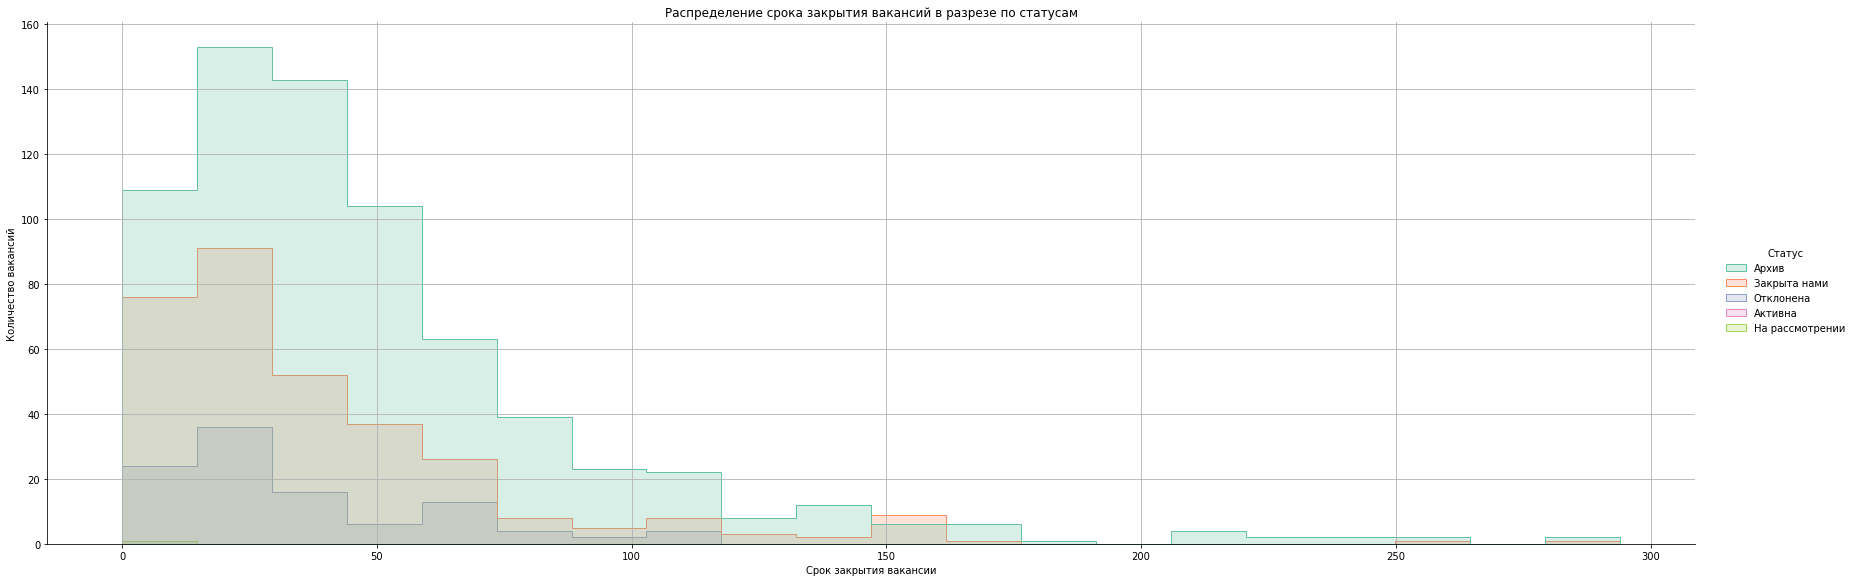

In [9]:
sns.displot(vacancy, x='Срок закрытия вакансии',
            hue="Статус",
            element="step",
            bins=20,
           height=8, aspect=3,palette='Set2')
plt.grid()
plt.ylabel('Количество вакансий')
plt.title('Распределение срока закрытия вакансий в разрезе по статусам')
plt.show()


___
*  Наибольшее число вакансий закрываются в первые 25 дней. Однако среди вакансий со статусом "Закрыта нами" Есть вакансии, которые висели более 70 дней
___


Сформулируем нулевую гипотезу: `Вакансии, выставленные агентством менее 25 дней, закрываются также как вакансии, размещенные более 25 дней .`

Альтернативная гипотеза: `Вакансии закрываются лучше в первые 25 дней после размещения.`

Для проверки гипотезы будем использовать t-test. Разделим данные на две группы (вакансии, закрытые за сроки до 25 дней и более 25 дней), а затем проведем t-тест для сравнения средних значений успешно закрытых вакансий в этих группах.


In [10]:
vacancy_test1 = vacancy[['Срок закрытия вакансии','Статус']]
vacancy_test1['Успешно закрыта'] = vacancy_test1['Статус'].map({"Закрыта нами": 1}).fillna(0)
vacancy_test1


# Разделяем данные на две группы: вакансии закрытые за сроки до 25 дней и более 70 дней
group_short = vacancy_test1[vacancy_test1['Срок закрытия вакансии'] <= 25]['Успешно закрыта']
group_long = vacancy_test1[vacancy_test1['Срок закрытия вакансии'] > 25]['Успешно закрыта']

# Выполняем t-тест, предполагая несвязанные выборки и двустороннюю альтернативу
t_statistic, p_value = stats.ttest_ind(group_short, group_long, equal_var=False)

alpha = 0.05

if p_value < alpha:
    print("Результаты t-теста показывают статистически значимую разницу между привлекательностью вакансий и сроком закрытия.")
else:
    print("Статистически значимой разницы между привлекательностью вакансий и сроком закрытия не выявлено.")

Результаты t-теста показывают статистически значимую разницу между привлекательностью вакансий и сроком закрытия.


C:\Users\scheo\AppData\Local\Temp/ipykernel_13624/1684204245.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Вывод**
____
Выявлена статистически значимая разница между выборками закрытых вакансий со сроками закрытия  менее 25 дней и более 25 дней.
Отвергаем гипотезу. Наибольшая вероятность того, что вакансия будет успешно закрыта при сроке рассмотрения вакансии до 25 дней. Если вакансия
"висит" более 25 дней, вероятность успешного закрытия мала.
___

#### **Формат работы**


Рассмотрим доли статусов вакансий по каждому из форматов работы.

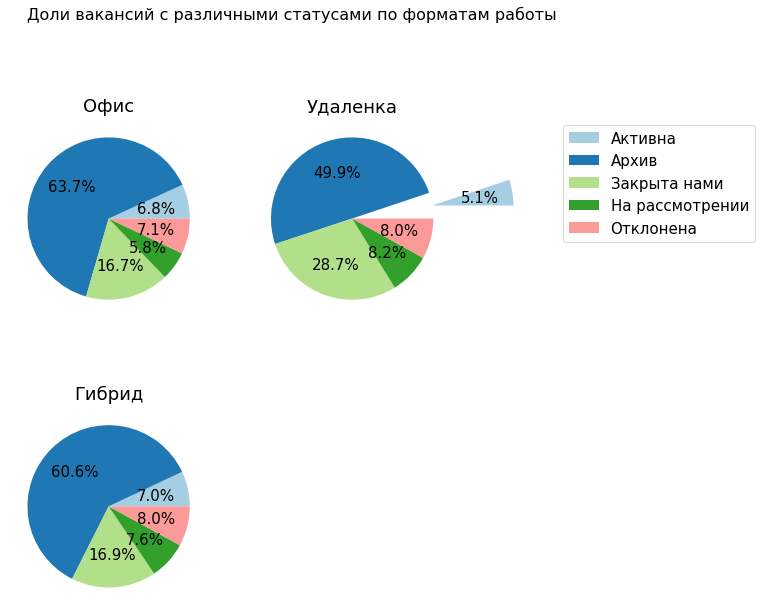

In [11]:
employment = vacancy['Формат работы'].unique().tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))




fig = plt.figure(figsize=(8, 15))
for f in range(0,len(form)):
    colors = sns.color_palette('Paired')[0:5]
    plt.rc('font', size= 15 )
    plt.subplot(3, 2, f+1)
    pie_data = vacancy[vacancy['Формат работы'].str.contains(form[f], case=True)].groupby('Статус')['id'].count()

    explode = (pie_data / vacancy[vacancy['Формат работы'] == form[f]]['id'].count() < 0.1).astype(float)
    plt.pie(pie_data, autopct='%1.1f%%',
            colors=colors,
           explode=explode)
    plt.title(form[f])

    if f==1:
        plt.legend(pie_data.index, bbox_to_anchor=(1.50, 1))
plt.text(-1, 6, "Доли вакансий с различными статусами по форматам работы", fontsize=16, color='black')
plt.show()

___
* Наибольший процент вакансий, закрытых агентством, наблюдается при удаленном формате работы. 28% всех вакансий с удаленным форматом были успешно закрыты.
* Меньше всего закрывались вакансии с форматами гибрид и офис.
___

Нулевая гипотеза: `Вакансии с удаленным и другими форматами закрываются одинаково`

Альтернативная гипотеза: `Вакансии с удаленным форматом работы имеют больше шансов быть успешно закрытыми агентством по сравнению с вакансиями с гибридным форматом`

В качестве метода проверки будем использовать Z-тест для пропорций. Проверим равенство долей закрытых вакансий с удаленным и другими форматами работы

In [12]:
# Все вакансии
city_list = vacancy['Формат работы'].tolist()
alls  = list(map(lambda x: ['Удаленка',1] if x.__contains__('Удаленка') else ['Другие',1], city_list))
alls = pd.DataFrame(alls ).groupby(by=0).agg('sum')[1].tolist()
# только успешно закрытые
city_list = vacancy[vacancy['Статус'] == 'Закрыта нами']['Формат работы'].tolist()
close = list(map(lambda x: ['Удаленка',1] if x.__contains__('Удаленка') else ['Другие',1], city_list))
close = pd.DataFrame(close).groupby(by=0).agg('sum')[1].tolist()

alpha = .05 # критический уровень статистической значимости

successes = np.array([close[0],close[1] ]) # успешно закрытых вакансий удаленка / гибрид
trials = np.array([alls[0], alls[1]]) # # все вакансии удаленка / гибрид

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

# # считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Между долями есть значимая разница')
else:
    print(
        'Нет оснований считать доли разными'
    )

p-значение:  1.8796435947709966e-06
Между долями есть значимая разница


**Вывод**
_____
Есть значимая разница между долей закрытых вакансий с удаленным форматом работы и долей закрытых вакансий с другими форматами. Гипотеза подтверждается - вакансии с удаленным форматом имеют больше шансов быть закрытыми силами агентства.
___

#### **Наличие ссылки на тестовое**


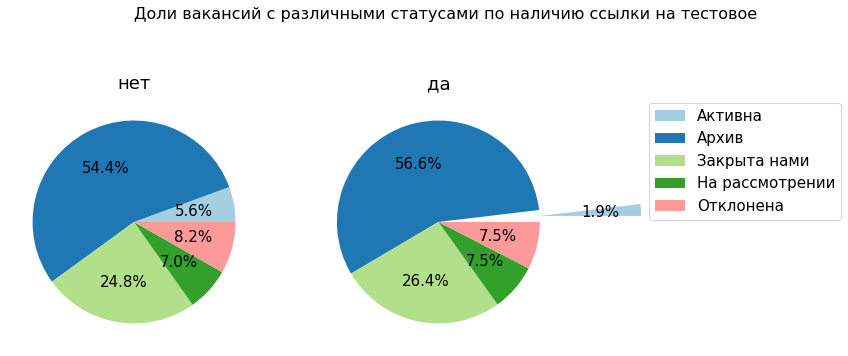

In [13]:
form = vacancy['Ссылка на тестовое'].unique().tolist()

fig = plt.figure(figsize=(10, 20))
for f in range(0,len(form)):
    colors = sns.color_palette('Paired')[0:5]
    plt.rc('font', size= 15 )
    plt.subplot(2, 2, f+1)
    pie_data = vacancy[vacancy['Ссылка на тестовое'] == form[f]].groupby('Статус')['id'].count()

    if len(pie_data) < 5:
        A = pd.Series(index = vacancy['Статус'].unique().tolist(), data = 0)
        B = pd.Series(vacancy[vacancy['Ссылка на тестовое'] == form[f]].value_counts('Статус'))
        df = pd.concat([B, A ], axis= 1).fillna(0)[0]
        pie_data  = df.sort_index(ascending=True)

    explode = (pie_data / vacancy[vacancy['Ссылка на тестовое'] == form[f]]['id'].count() < 0.048).astype(float)
    plt.pie(pie_data, autopct='%1.1f%%',
            colors=colors,
           explode=explode)
    plt.title(form[f])

    if f==1:
        plt.legend(pie_data.index, bbox_to_anchor=(1.30, 1))
plt.text(-3, 2, "Доли вакансий с различными статусами по наличию ссылки на тестовое", fontsize=16, color='black')
plt.show()

___
* Различия в долях закрытых вакансий от наличия ссылки на тестовое незначительные. Среди вакансий с указанной ссылкой на тестовое задание 26.4% успешно закрыты, без ссылки - 24,8%
___

Сформулируем нулевую гипотезу:  `Вакансии с указанием ссылки на тестовое задание и без нее имеют равную вероятность к успешному закрытию`

Альтернативная гипотеза: `Наличие ссылки на тестовое влияет на успешность закрытия вакансий`

В качестве метода будем использовать `t-test`

In [14]:
vacancy_test2= vacancy[['Ссылка на тестовое','Статус']]
vacancy_test2['Успешно закрыта'] = vacancy_test1['Статус'].map({"Закрыта нами": 1}).fillna(0)
vacancy_test2

# Разделяем данные на две группы: вакансии закрытые за сроки до 25 дней и более 70 дней
group_short = vacancy_test2[vacancy_test2['Ссылка на тестовое'] == 'да']['Успешно закрыта']
group_long = vacancy_test2[vacancy_test2['Ссылка на тестовое'] == 'нет']['Успешно закрыта']

# Выполняем t-тест, предполагая несвязанные выборки и двустороннюю альтернативу
t_statistic, p_value = stats.ttest_ind(group_short, group_long, equal_var=False)

alpha = 0.05

if p_value < alpha:
    print("Результаты t-теста показывают статистически значимую разницу между успешным закрытием  вакансий и наличием ссылки на тестовое задание.")
else:
    print("Статистически значимой разницы между успешным закрытием  вакансий и наличием ссылки на тестовое задание не выявлено.")


Статистически значимой разницы между успешным закрытием  вакансий и наличием ссылки на тестовое задание не выявлено.


C:\Users\scheo\AppData\Local\Temp/ipykernel_13624/4289241011.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Вывод**
_____
Нулевая гипотеза подтвердилась. Вакансии с указанием ссылки на тестовое задание и без нее закрываются одинаково
___

#### Факт указания зарплаты

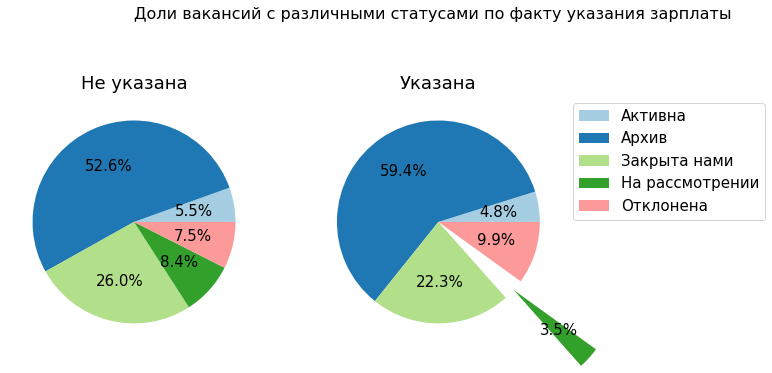

In [15]:
form = vacancy['Указана ли зарплата'].unique().tolist()

fig = plt.figure(figsize=(10, 20))
for f in range(0,len(form)):
    colors = sns.color_palette('Paired')[0:5]
    plt.rc('font', size= 15 )
    plt.subplot(2, 2, f+1)
    pie_data = vacancy[vacancy['Указана ли зарплата'] == form[f]].groupby('Статус')['id'].count()

    if len(pie_data) < 5:
        A = pd.Series(index = vacancy['Статус'].unique().tolist(), data = 0)
        B = pd.Series(vacancy[vacancy['Указана ли зарплата'] == form[f]].value_counts('Статус'))
        df = pd.concat([B, A ], axis= 1).fillna(0)[0]
        pie_data  = df.sort_index(ascending=True)

    explode = (pie_data / vacancy[vacancy['Указана ли зарплата'] == form[f]]['id'].count() < 0.048).astype(float)
    plt.pie(pie_data, autopct='%1.1f%%',
            colors=colors,
           explode=explode)

    if form[f] == True:
        plt.title('Указана')
    else:
        plt.title('Не указана')

    if f==1:
        plt.legend(pie_data.index, bbox_to_anchor=(1.00, 1))
plt.text(-3, 2, "Доли вакансий с различными статусами по факту указания зарплаты", fontsize=16, color='black')
plt.show()

___
* Наличие зарплатной "вилки" в вакансии не сильно влияет на успешность ее закрытия.
* Успешно закрыты 26% вакансий без указания зарплаты против 22,3% вакансий с указанием зарплаты.
___

Посмотрим, как распределены зарплаты в вакансиях со статусами "Закрыта нами" и "Отклонена"

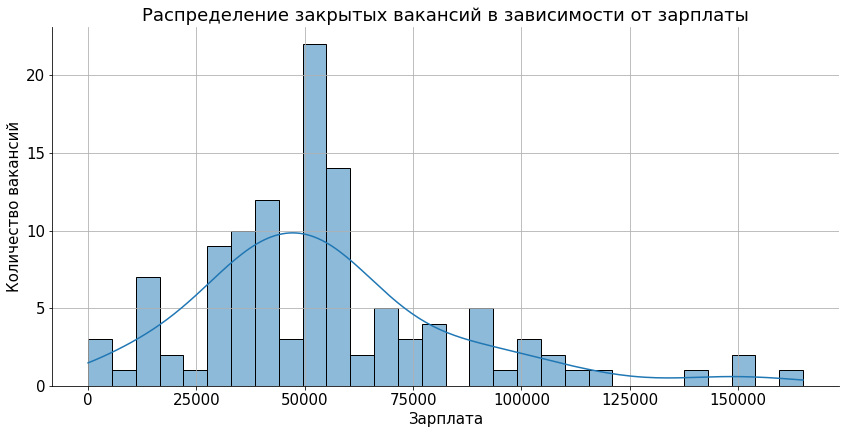

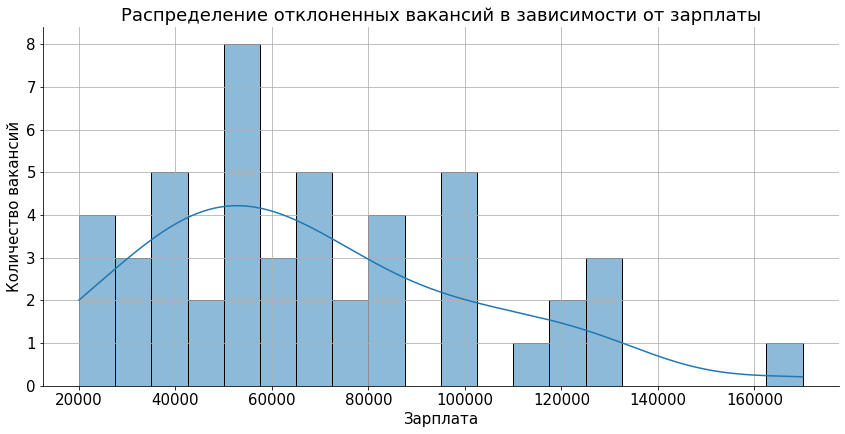

In [16]:
sns.displot(vacancy[vacancy["Статус"]=='Закрыта нами'], x='Зарплата',
            bins=30,
           height=6, aspect=2,kde=True)
plt.grid()
plt.ylabel('Количество вакансий')
plt.title('Распределение закрытых вакансий в зависимости от зарплаты')
plt.show()

sns.displot(vacancy[vacancy["Статус"]=='Отклонена'], x='Зарплата',
            bins=20,
           height=6, aspect=2,kde=True)
plt.grid()
plt.ylabel('Количество вакансий')
plt.title('Распределение отклоненных вакансий в зависимости от зарплаты')
plt.show()

___
* В большинстве закрытых вакансий с указанной зарплатой зарплата составляет 30 000 - 50 000 руб.
* Однако в отклоненных вакансиях при зарплате 50 000 наблюдается пик распределения.
* Распределения неравномерны что говорит о том, что зарплата не сильно влияет на успешность закрытия вакансии
___

Сформулируем нулевую гипотезу: `Факт указания зарплаты не влияет на успешность закрытия вакансии агентством`

Альтернативная гипотеза: `Есть влияние факта указание зарплаты на успешность закрытия вакансии`

Метод проверки гипотезы: t-test

In [17]:
vacancy_test3= vacancy[['Указана ли зарплата','Статус']]
vacancy_test3['Успешно закрыта'] = vacancy_test1['Статус'].map({"Закрыта нами": 1}).fillna(0)
vacancy_test3

# Разделяем данные на две группы: вакансии закрытые за сроки до 25 дней и более 25 дней
group_short = vacancy_test3[vacancy_test3['Указана ли зарплата'] == True]['Успешно закрыта']
group_long = vacancy_test3[vacancy_test3['Указана ли зарплата'] == False]['Успешно закрыта']

# Выполняем t-тест, предполагая несвязанные выборки и двустороннюю альтернативу
t_statistic, p_value = stats.ttest_ind(group_short, group_long, equal_var=False)

alpha = 0.05

if p_value < alpha:
    print("Результаты t-теста показывают статистически значимую разницу между успешным закрытием  вакансий и фактом указания зарплаты")
else:
    print("Статистически значимой разницы между успешным закрытием  вакансий и фактом указания зарплаты не выявлено.")

Статистически значимой разницы между успешным закрытием  вакансий и фактом указания зарплаты не выявлено.


C:\Users\scheo\AppData\Local\Temp/ipykernel_13624/2935414271.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Вывод**
___
По результатам t-теста нулевая гипотеза подтвердилась - вакансии закрываются одинаково вне зависимости указана в них зарплата или нет
____

#### **Источник лида**

Есть 4 источника вакансии: `Входящая заявка` - заказчик сам заполнил форму на сайте КА, `Сорсинг` - менеджеры КА привлекли заказчика исходящим поиском, `Повторная` - это не первая вакансия компании, подбор на которую будет делать КА, `Реферальная` - заказчик пришел в КА по рекомендации от другого заказчика.

Посмотрим, как влияет источник лида на успешное закрытие вакансии.

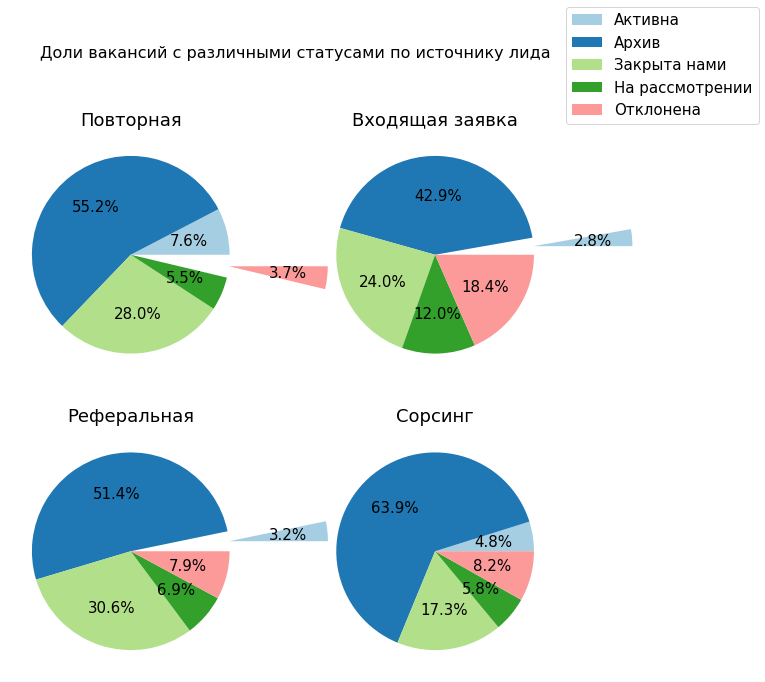

In [18]:
form = vacancy['Источник лида'].dropna().unique().tolist()

fig = plt.figure(figsize=(10, 10))
for f in range(0,len(form)):
    colors = sns.color_palette('Paired')[0:5]
    plt.rc('font', size= 15 )
    plt.subplot(2, 2, f+1)
    pie_data = vacancy[vacancy['Источник лида'] == form[f]].groupby('Статус')['id'].count()

    if len(pie_data) < 5:
        A = pd.Series(index = vacancy['Статус'].unique().tolist(), data = 0)
        B = pd.Series(vacancy[vacancy['Источник лида'] == form[f]].value_counts('Статус'))
        df = pd.concat([B, A ], axis= 1).fillna(0)[0]
        pie_data  = df.sort_index(ascending=True)

    explode = (pie_data / vacancy[vacancy['Источник лида'] == form[f]]['id'].count() < 0.048).astype(float)
    plt.pie(pie_data, autopct='%1.1f%%',
            colors=colors,
           explode=explode)
    plt.title(form[f])

    if f==1:
        plt.legend(pie_data.index, bbox_to_anchor=(1.00, 1))
plt.text(-4, 5, "Доли вакансий с различными статусами по источнику лида", fontsize=16, color='black')
plt.show()

___
* Больше всего успешно закрытых вакансий по вакансиям с рефиральным источником лида - 30,6%.
* Чуть меньше у повторных вакансий - 28%
* Среди вакансий с входящей заявкой имеют значительно больший процент отклоненных 18,4%
___


Нулевая гипотеза: Источник лида не влияет на успешность закрытия вакансии
Альтернативная гипотеза: Источник лида влияет на успешность закрытия вакансии

В качестве метода для проверки гипотезы будем использовать тест Хи-квадрат.

In [19]:
data = vacancy
observed = pd.crosstab(data['Источник лида'], data['Статус'], margins = True)
chi2, p, dof, expected = chi2_contingency(observed)
alpha = 0.05
print("Хи-квадрат статистика:", chi2)
print("p-значение:", p)
if p < alpha:
    print("Отвергаем нулевую гипотезу: Источник лида влияет на успешное закрытие вакансии")
else:
    print("Не удалось отвергнуть нулевую гипотезу: Вакансии с разными источниками лида закрываются одинаково")

Хи-квадрат статистика: 84.34643947060754
p-значение: 7.094518672163809e-10
Отвергаем нулевую гипотезу: Источник лида влияет на успешное закрытие вакансии


**Вывод**
___
Статистический тест показал, что источник лида влияет на успешность закрытия вакансии.
___

#### **Город**

In [20]:
employment = vacancy['Город'].unique().tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))

Найдем топ-5 городов, которые встречаются в описаниях вакансий.

In [21]:
frequency_cities = []
for c in form:
    vacancy[vacancy['Город'].str.contains(c, case=True)]['id'].count()
    frequency_cities.append([c,vacancy[vacancy['Город'].str.contains(c, case=True)]['id'].count()])
frequency_cities = pd.DataFrame(frequency_cities)
frequency_cities.columns = ['Город','Количество']
frequency_cities = frequency_cities.sort_values('Количество', ascending = False)
frequency_cities.head(5)

c:\users\scheo\appdata\local\programs\python\python39\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



Город  Количество
83           Москва         964
81  Санкт-Петербург         195
59           Казань          35
26     Екатеринбург          25
0            Самара          20

Посмотрим распределение успешно закрытых вакансий по 5 самым популярным городам.

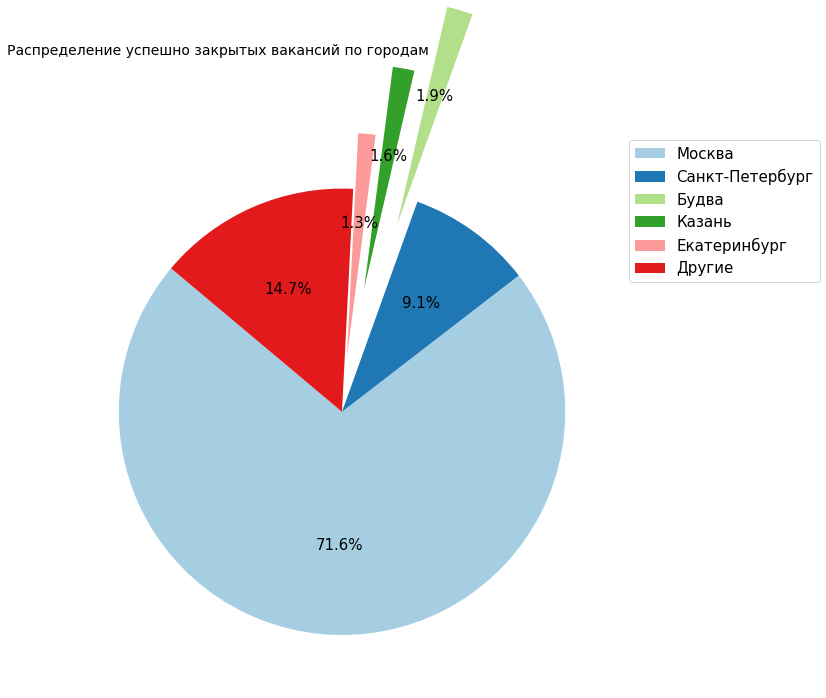

In [22]:

data = vacancy[vacancy['Статус']=='Закрыта нами']

top_cities = data.groupby('Город').size().nlargest(5)


other_cities = data[~data['Город'].isin(top_cities.index)].groupby('Город').size().sum()
top_cities['Другие'] = other_cities


fig = plt.figure(figsize=(10, 20))
colors = sns.color_palette('Paired')[0:11]
plt.rc('font', size= 15 )

explode = []
for i in top_cities:
    if i*100/sum(top_cities)<=2:
        explode.append(i*100/sum(top_cities) - 1)
    else:
        explode.append(0)

plt.pie(top_cities,
        startangle=140,autopct='%1.1f%%',
            colors=colors, explode =explode )



plt.text(-1.5, 1.6, "Распределение успешно закрытых вакансий по городам", fontsize=14, color='black')
plt.legend(top_cities.index, bbox_to_anchor=(1.00, 1))
plt.show()

___
* Видно, что 71,6% всех успешно закрытых вакансий предлагают работу в Москве
* На города, не вошедшие в пятерку самых популярных, приходится 14,7%  успешно закрытых вакансий.
____

Нулевая гипотеза: `Вакансии закрываются одинаково во всех городах.`

Альтернативная гипотеза: `Лучше всего вакансии закрываются в Москве`


В качестве метода проверки будем использовать Z-тест для пропорций. Проверим равенство долей закрытых вакансий с указанием города Москва и другими городами

In [23]:
# Все вакансии
city_list = vacancy['Город'].tolist()
alls  = list(map(lambda x: ['Москва',1] if x.__contains__('Москва') else ['Не Москва',1], city_list))
alls = pd.DataFrame(alls ).groupby(by=0).agg('sum')[1].tolist()
# только успешно закрытые
city_list = vacancy[vacancy['Статус'] == 'Закрыта нами']['Город'].tolist()
close = list(map(lambda x: ['Москва',1] if x.__contains__('Москва') else ['Не Москва',1], city_list))
close = pd.DataFrame(close).groupby(by=0).agg('sum')[1].tolist()

alpha = .05 # критический уровень статистической значимости

successes = np.array([close[0],close[1] ]) # успешно закрытых вакансий удаленка / гибрид
trials = np.array([alls[0], alls[1]]) # # все вакансии удаленка / гибрид

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

# # считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Между долями есть значимая разница')
else:
    print(
        'Нет оснований считать доли разными'
    )

p-значение:  0.5758716091348837
Нет оснований считать доли разными


**Вывод**
___
Статистический тест не показал различия в долях, значит мы не можем считать, что вакансии с указанием города Москва закрываются лучше остальных.
___

#### Общий вывод из анализа признаков вакансий, успешно закрытых агентством
___
* Вакансии закрываются лучше в первые 25 дней после размещения
* Вакансии с удаленным форматом имеют больше шансов быть закрытыми силами агентства, чем вакансии с гибридным форматом
* Источник лида влияет на успешность закрытия вакансии - лучше закрываются вакансии с реферальным источником лида
* Наличие ссылки на тестовое задание, факт указания заработной платы, а также город на успешность закрытия вакансий не влияют
___

<a id='part_2'></a>
### Анализ признаков вакансий привлекающих наибольшее внимание кандидатов

Посмотрим, как распределено количество просмотров и откликов по всем вакансиям

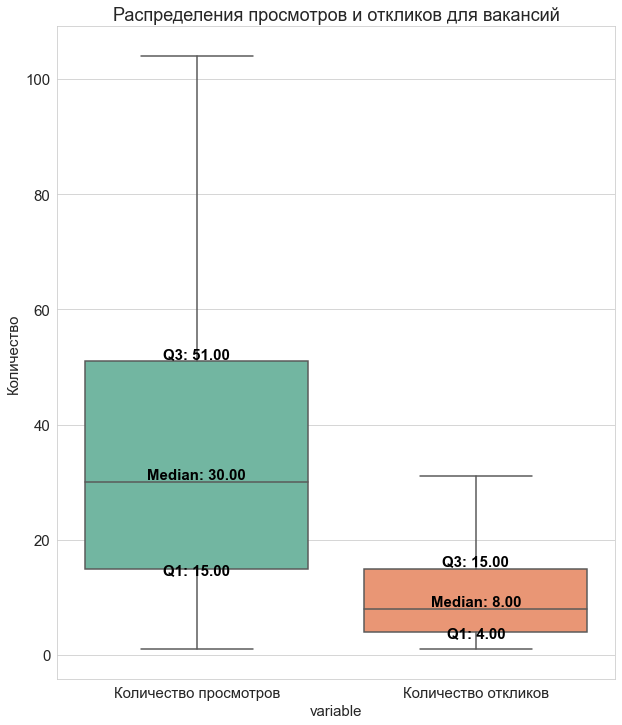

In [24]:
# Создаем один график за пределами цикла
plt.figure(figsize=(10, 12))
sns.set_style("whitegrid")  # Добавление сетки
sns.set_palette("Set2")

# Рисуем боксплоты для каждой категории на одном графике
ax = sns.boxplot(x='variable', y='value', data=pd.melt(vacancy[['Количество просмотров', 'Количество откликов']]), showfliers=False)

# Добавляем подписи для медианы и квартилей
for i in range(len(ax.artists)):
    box = ax.artists[i]

    # Получаем статистики
    meds = vacancy[['Количество просмотров', 'Количество откликов', 'CTR']].median()
    q1 = vacancy[['Количество просмотров', 'Количество откликов', 'CTR']].quantile(0.25)
    q3 = vacancy[['Количество просмотров', 'Количество откликов', 'CTR']].quantile(0.75)

    # Добавляем подписи
    ax.text(i, meds[i]+0.5, f'Median: {meds[i]:.2f}', horizontalalignment='center', color='black', weight='semibold')
    ax.text(i, q1[i]-1, f'Q1: {q1[i]:.2f}', horizontalalignment='center', color='black', weight='semibold')
    ax.text(i, q3[i]+0.5, f'Q3: {q3[i]:.2f}', horizontalalignment='center', color='black', weight='semibold')

plt.title('Распределения просмотров и откликов для вакансий')
plt.ylabel('Количество')

plt.show()

___
* Количество просмотров распределено в пределах от 15 до 51 просмотра на вакансию. Наблюдаются также вакансии с более чем 100 просмотрами. Более половины вакансий имеют 30 просмотров и более
* Отклики распределены от 4 до 15 откликов на вакансию. Медианное значение 8
___

Выделим признаки вакансий , привлекающих наибольшее внимание кандидатов:

* Формат работы
* Занятость
* Количество городов указанных в вакансии
* Наличие ссылки на тестовое
* Формат оформления
* Образование


#### Формат работы

Рассмотрим доли откликов и просмотров для различных форматов работы

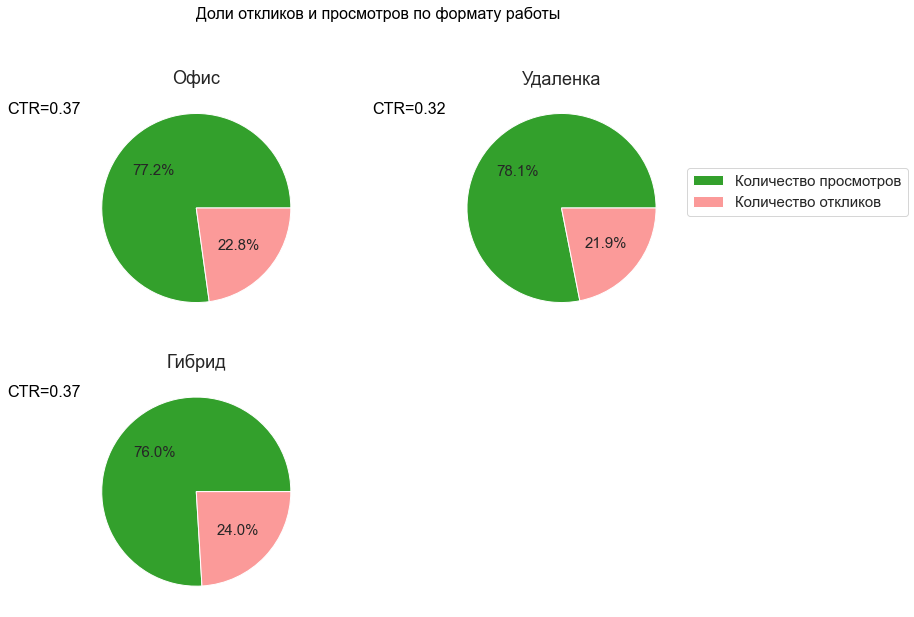

In [25]:
data = vacancy
employment = vacancy['Формат работы'].unique().tolist()
employment_list = vacancy['Формат работы'].tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))

fig = plt.figure(figsize=(12, 20))
for f in range(0,len(form)):
    colors = sns.color_palette('Paired')[3:8]
    plt.rc('font', size= 15 )
    plt.subplot(4, 2, f+1)

    views = pd.Series({'Количество просмотров':data[pd.Series(map(lambda x:  x.__contains__(form[f]) , employment_list))]['Количество просмотров'].sum()})
    responses = pd.Series({'Количество откликов':data[pd.Series(map(lambda x:  x.__contains__(form[f]) , employment_list))]['Количество откликов'].sum()})
    pie_data = pd.concat([views,responses],axis= 0)
    ctr = round(vacancy[list(map(lambda x:  x.__contains__(form[f]) , employment_list))]['CTR'].mean(),2)

    plt.pie(pie_data, autopct='%1.1f%%',
            colors=colors)
           # explode=explode)
    plt.title(form[f])
    plt.text(-2, 1, f'CTR={ctr}', fontsize=16, color='black')

    if f==1:
        plt.legend(pie_data.index, bbox_to_anchor=(1.00, 0.7))



plt.text(0, 5, "Доли откликов и просмотров по формату работы", fontsize=16, color='black')
plt.show()

___
* Наименьшая конверсия в отклики (32%) у вакансий, предлагающих  удаленную работу
* Однако конверсия и количество откликов по разным форматам работы сильно не отличаются
___

Сформулируем нулевую гипотезу: `Формат работы не влияет на количество откликов на вакансию`

Альтернативная гипотеза: `Формат работы влияет на количество откликов на вакансию`

Проведем множественную проверку гипотез с помощью однофакторного ANOVA-анализа. Проверим имеют ли статистически значимые различия каждый из форматов работы от остальных. Метод Холма будем использовать в качестве поправки на множественное сравнение.


In [26]:

data = vacancy

employment = vacancy['Формат работы'].unique().tolist()
employment_list = vacancy['Формат работы'].tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))

p_value = []

for f in form:

    employment_list = data['Формат работы'].tolist()
    full_time_data = data[pd.Series(map(lambda x:  x.__contains__(f) , employment_list))]['Количество откликов']
    other_data = data[pd.Series(map(lambda x:  not x.__contains__(f) , employment_list))]['Количество откликов']


    f_stat, p_val = f_oneway(full_time_data, other_data)
    p_value.append(p_val)


alpha = 0.05

# Применяем метод Холма для коррекции p-значений
reject, corrected_p_values, alphacSidak, alphacBonf = multipletests(p_value, method='holm')

# Выводим результаты
results = pd.DataFrame({'corrected_p_values':corrected_p_values})


for f in range(len(form)):
    if results.loc[f,'corrected_p_values'] < alpha:
        print(f"Отвергаем нулевую гипотезу: Есть статистически значимые различия в среднем количестве откликов между вакансиями  с типом занятости {form[f]} и другими")
    else:
        print(f"Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с типом занятости {form[f]} и другими")
    print(' ')

Отвергаем нулевую гипотезу: Есть статистически значимые различия в среднем количестве откликов между вакансиями  с типом занятости Офис и другими
 
Отвергаем нулевую гипотезу: Есть статистически значимые различия в среднем количестве откликов между вакансиями  с типом занятости Удаленка и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с типом занятости Гибрид и другими
 


**Вывод**
___
При множественной проверке ANOVA-анализ показал значимые различия в среднем количестве откликов между вакансиями  с типом занятости Удаленка и Офис по сравнению с другими форматами
___


#### **Занятость**


Рассмотрим доли откликов и просмотров по типам занятости

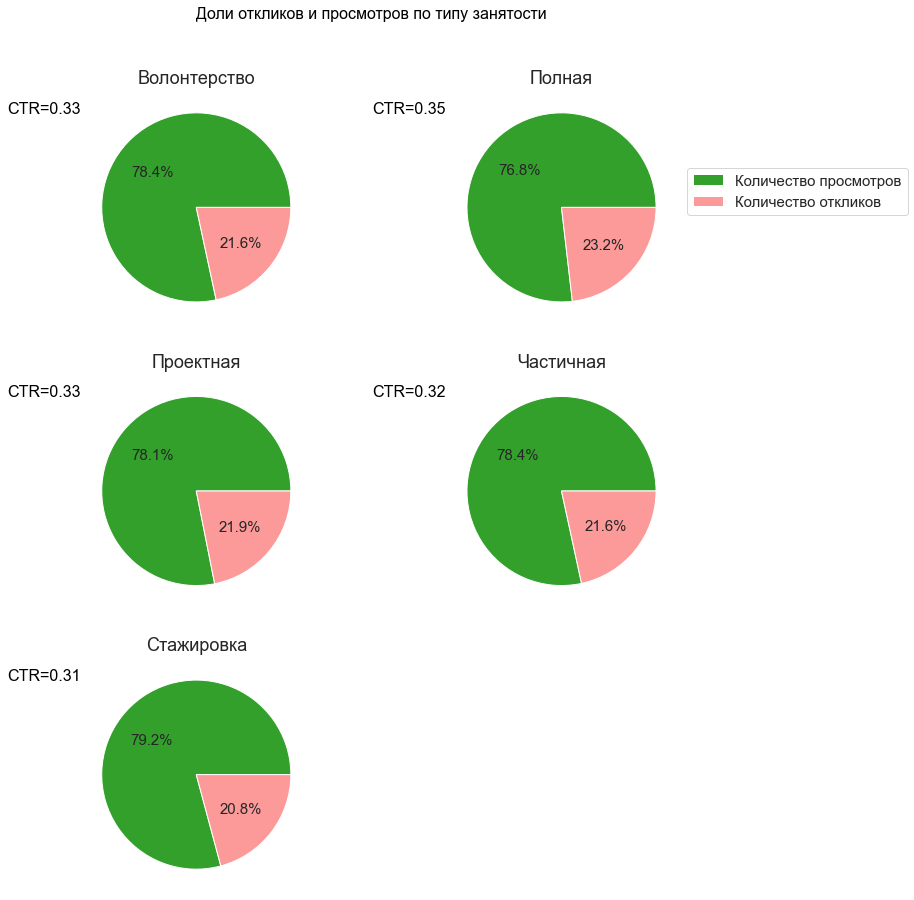

In [27]:
data = vacancy
employment = vacancy['Занятость'].unique().tolist()
employment_list = vacancy['Занятость'].tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))

fig = plt.figure(figsize=(12, 20))
for f in range(0,len(form)):
    colors = sns.color_palette('Paired')[3:8]
    plt.rc('font', size= 15 )
    plt.subplot(4, 2, f+1)

    views = pd.Series({'Количество просмотров':data[pd.Series(map(lambda x:  x.__contains__(form[f]) , employment_list))]['Количество просмотров'].sum()})
    responses = pd.Series({'Количество откликов':data[pd.Series(map(lambda x:  x.__contains__(form[f]) , employment_list))]['Количество откликов'].sum()})
    pie_data = pd.concat([views,responses],axis= 0)
    ctr = round(vacancy[list(map(lambda x:  x.__contains__(form[f]) , employment_list))]['CTR'].mean(),2)

    plt.pie(pie_data, autopct='%1.1f%%',
            colors=colors)
           # explode=explode)
    plt.title(form[f])
    plt.text(-2, 1, f'CTR={ctr}', fontsize=16, color='black')

    if f==1:
        plt.legend(pie_data.index, bbox_to_anchor=(1.00, 0.7))



plt.text(0, 8, "Доли откликов и просмотров по типу занятости", fontsize=16, color='black')
plt.show()

___
* Наибольшее число откликов, а также наибольшая конверсия в отклики наблюдается у вакансий, предлагающих полную занятость
* Хуже конверсия у стажировок и вакансий с частичной занятостью
___

Нулевая гипотеза:`Тип занятости не влияет на количество откликов на вакансию`

Альтернативная гипотеза: `Тип занятости влияет на количество откликов на вакансию`

Для проверки гипотезы будем использовать однофакторный ANOVA-анализ и метод Холма, в качестве поправки на множественное сравнение.

In [28]:

data = vacancy

employment = vacancy['Занятость'].unique().tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))

p_value = []

for f in form:

    employment_list = data['Занятость'].tolist()
    full_time_data = data[pd.Series(map(lambda x:  x.__contains__(f) , employment_list))]['Количество откликов']
    other_data = data[pd.Series(map(lambda x:  not x.__contains__(f) , employment_list))]['Количество откликов']


    f_stat, p_val = f_oneway(full_time_data, other_data)
    p_value.append(p_val)


alpha = 0.05

# Применяем метод Холма для коррекции p-значений
reject, corrected_p_values, alphacSidak, alphacBonf = multipletests(p_value, method='holm')

# Выводим результаты
results = pd.DataFrame({'corrected_p_values':corrected_p_values})


for f in range(len(form)):
    if results.loc[f,'corrected_p_values'] < alpha:
        print(f"Отвергаем нулевую гипотезу: Есть статистически значимые различия в среднем количестве откликов между вакансиями  с типом занятости {form[f]} и другими")
    else:
        print(f"Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с типом занятости {form[f]} и другими")
    print(' ')

Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с типом занятости Волонтерство и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с типом занятости Полная и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с типом занятости Проектная и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с типом занятости Частичная и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с типом занятости Стажировка и другими
 


**Вывод**
___
ANOVA-анализ не показал значимой разницы между типами занятости
___

#### Город

Выделим Топ-10 городов с наибольшим количеством откликов и посчитаем для них медианно значение конверсии в отклики

In [29]:
employment = vacancy['Город'].unique().tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))

frequency_cities = []
for c in form:
    frequency_cities.append([c,
                             vacancy[vacancy['Город'].str.contains(c, case=True)]['Количество откликов'].sum(),
                            round(vacancy[vacancy['Город'].str.contains(c, case=True)]['CTR'].median(),2)])
frequency_cities = pd.DataFrame(frequency_cities)
frequency_cities.columns = ['Город','Количество откликов','CTR']
frequency_cities = frequency_cities.sort_values('Количество откликов', ascending = False)
frequency_cities.head(10)

c:\users\scheo\appdata\local\programs\python\python39\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



Город  Количество откликов   CTR
83           Москва                11113  0.30
81  Санкт-Петербург                 2101  0.29
59           Казань                  389  0.33
42             Тула                  367  0.33
26     Екатеринбург                  241  0.27
0            Самара                  229  0.42
63           Алматы                  211  0.33
44  Нижний Новгород                  198  0.38
72           Ростов                  140  0.29
68   Ростов-на-Дону                  137  0.32

Посмотрим как распределена конверсия в отклики для топ-10 городов

In [30]:
numb_of_responses = vacancy.groupby(by = 'Формат работы',as_index=False)['Количество откликов'].agg('sum')
numb_of_responses
def auto_bar(col,group,func,title,ylabel = numb_of_responses.columns[1], data = vacancy):

    numb_of_responses = data.groupby(by = group,as_index=False)[col].agg(func)
    # функция для подписей столбчатой диаграммы
    def autolabel(rects, labels=None, height_factor=1.01):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            if labels is not None:
                try:
                    label = round(labels[i],2)
                except (TypeError, KeyError):
                    label = ' '
            else:
                label = '%d' % int(height)
            ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                    '{}'.format(label),
                    ha='center', va='bottom')

    warnings.filterwarnings('ignore')
    x=numb_of_responses[group].tolist()
    y=numb_of_responses[col].tolist()

    # sns.set_palette("Set3")
    # sns.set_palette('Paired')
    sns.catplot(x= x,
            y=y ,
            data = numb_of_responses,
            kind="bar", ci=True,
           height= 8 , aspect= 1.5, palette='Set2')
    plt.title(title)
    plt.xlabel(numb_of_responses.columns[0])
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)

    ax = plt.gca()

    autolabel(ax.patches, y, height_factor=1)
    return

In [31]:
frequency_cities.head(10)

Город  Количество откликов   CTR
83           Москва                11113  0.30
81  Санкт-Петербург                 2101  0.29
59           Казань                  389  0.33
42             Тула                  367  0.33
26     Екатеринбург                  241  0.27
0            Самара                  229  0.42
63           Алматы                  211  0.33
44  Нижний Новгород                  198  0.38
72           Ростов                  140  0.29
68   Ростов-на-Дону                  137  0.32

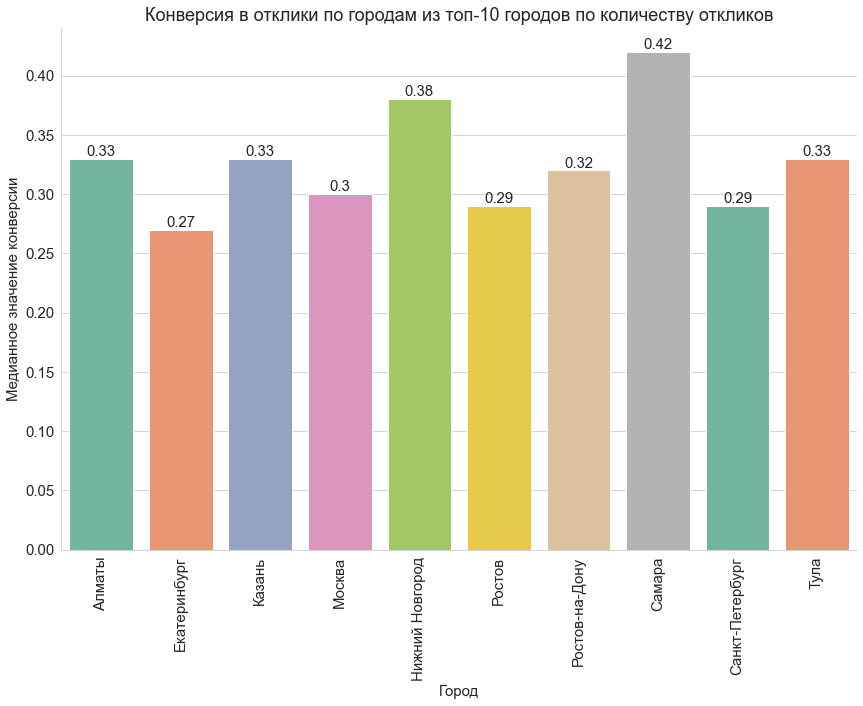

In [32]:
auto_bar('CTR',
         'Город',
         'median',
         'Конверсия в отклики по городам из топ-10 городов по количеству откликов',
         ylabel='Медианное значение конверсии',
         data = frequency_cities.head(10))

___
* Наибольшая конверсия наблюдается у Самары 42%
* Несмотря на то, что в Москве самое большое количество откликов, конверсия здесь всего 30%
___

Сформулируем нулевую гипотезу: `Конверсия в отклики в разных городах одинаковая`

Альтернативная гипотеза: `Город, указанный в вакансии, влияет на конверсию в отклики на вакансию`

В качестве метода проверки гипотезы будем использовать Хи-тест


In [33]:

data = frequency_cities

# Создадим таблицу сопряженности для видов занятости и успешно закрытых вакансий
observed = pd.crosstab(data['Город'], data['CTR'], margins = True)

# Выполним тест Хи-квадрат
chi2, p, dof, expected = chi2_contingency(observed)

# Уровень значимости
alpha = 0.05

# Печать результатов
print("Хи-квадрат статистика:", chi2)
print("p-значение:", p)
if p < alpha:
    print("Отвергаем нулевую гипотезу: Город, указанный в вакансии влияет на конверсию в отклики")
else:
    print("Не удалось отвергнуть нулевую гипотезу: Вакансии с указанием работы в разных городах имеют равную конверсию в отклики")

Хи-квадрат статистика: 3003.0
p-значение: 0.8769481663699823
Не удалось отвергнуть нулевую гипотезу: Вакансии с указанием работы в разных городах имеют равную конверсию в отклики


**Вывод**
___
Входе теста не удалось отвергнуть нулевую гипотезу - город не влияет на значение конверсии в отклики.
___

#### Наличие ссылки на тестовое

Посмотрим доли откликов и просмотров в зависимости от наличия ссылки на тестовое задание

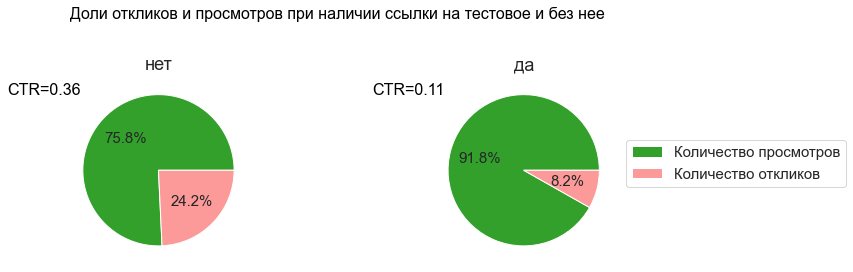

In [34]:
form = vacancy['Ссылка на тестовое'].unique().tolist()

fig = plt.figure(figsize=(12, 16))
for f in range(0,len(form)):
    colors = sns.color_palette('Paired')[3:8]
    plt.rc('font', size= 15 )
    plt.subplot(4, 2, f+1)
    views = pd.Series({'Количество просмотров':vacancy[vacancy['Ссылка на тестовое'] == form[f]]['Количество просмотров'].sum()})
    responses = pd.Series({'Количество откликов':vacancy[vacancy['Ссылка на тестовое'] == form[f]]['Количество откликов'].sum()})
    pie_data = pd.concat([views,responses],axis= 0)
    ctr = round(vacancy[vacancy['Ссылка на тестовое']==form[f]]['CTR'].mean(),2)

    plt.pie(pie_data, autopct='%1.1f%%',
            colors=colors)
           # explode=explode)
    plt.title(form[f])
    plt.text(-2, 1, f'CTR={ctr}', fontsize=16, color='black')

    if f==1:
        plt.legend(pie_data.index, bbox_to_anchor=(1.00, 0.7))



plt.text(-6, 2, "Доли откликов и просмотров при наличии ссылки на тестовое и без нее", fontsize=16, color='black')
plt.show()

___
Конверсия в отклики больше у вакансий без ссылки на тестовое задание
___

Сформулируем нулевую гипотезу: `Наличие ссылки на тестовое не влияет на количество откликов на вакансию`

Альтернативная гипотеза: `Наличие ссылки на тестовое влияет на количество откликов на вакансию`

Для проверки гипотезы будем использовать двусторонний тест Манна-Уитни

In [35]:

data = vacancy

# Отделение данных ваканций с ссылкой на тестовое задание и без
with_link = data[data['Ссылка на тестовое'] == 'да']['Количество откликов']
without_link = data[data['Ссылка на тестовое'] == 'нет']['Количество откликов']

# Проведение теста Манна-Уитни
stat, p_val = mannwhitneyu(with_link, without_link, alternative='less')  # Тест на меньшее количество откликов

alpha = 0.05

# Вывод результатов
print("Статистика теста:", stat)
print("p-значение:", p_val)
if p_val < alpha:
    print("Отвергаем нулевую гипотезу: Вакансии без ссылки на тестовое задание имеют больше откликов")
else:
    print("Не удалось отвергнуть нулевую гипотезу: Нет статистически значимых различий в количестве откликов между вакансиями без и с ссылкой на тестовое задание")

Статистика теста: 39862.0
p-значение: 3.163326108252922e-10
Отвергаем нулевую гипотезу: Вакансии без ссылки на тестовое задание имеют больше откликов


**Вывод**
___
Двусторонний тест Манна-Уитни показал, что вакансии без ссылки на тестовое задание имеют больше откликов
___

#### Формат оформления

Рассмотрим доли откликов и просмотров в зависимости от формата оформления

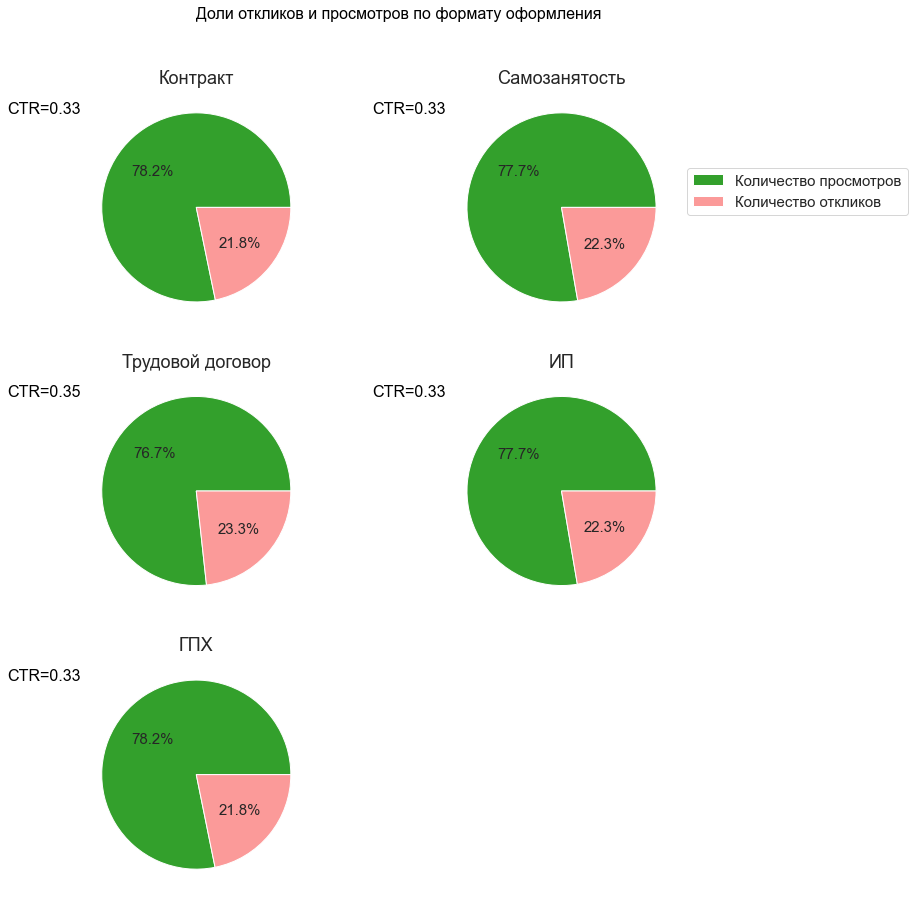

In [36]:
employment = vacancy['Формат оформления'].unique().tolist()
employment_list = vacancy['Формат оформления'].tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))

fig = plt.figure(figsize=(12, 20))
for f in range(0,len(form)):
    colors = sns.color_palette('Paired')[3:8]
    plt.rc('font', size= 15 )
    plt.subplot(4, 2, f+1)

    views = pd.Series({'Количество просмотров':data[pd.Series(map(lambda x:  x.__contains__(form[f]) , employment_list))]['Количество просмотров'].sum()})
    responses = pd.Series({'Количество откликов':data[pd.Series(map(lambda x:  x.__contains__(form[f]) , employment_list))]['Количество откликов'].sum()})
    pie_data = pd.concat([views,responses],axis= 0)
    ctr = round(vacancy[list(map(lambda x:  x.__contains__(form[f]) , employment_list))]['CTR'].mean(),2)

    plt.pie(pie_data, autopct='%1.1f%%',
            colors=colors)
           # explode=explode)
    plt.title(form[f])
    plt.text(-2, 1, f'CTR={ctr}', fontsize=16, color='black')

    if f==1:
        plt.legend(pie_data.index, bbox_to_anchor=(1.00, 0.7))



plt.text(0, 8, "Доли откликов и просмотров по формату оформления", fontsize=16, color='black')
plt.show()

___
Конверсия в отклики практически одинакова для различных форматов оформления
___

Нулевая гипотеза: `Формат оформления не влияет на количество откликов`
Альтернативная гипотеза:  `Формат оформления влияет на количество откликов`

Для проверки гипотезы будем использовать однофакторный ANOVA-анализ и метод Холма, в качестве поправки на множественное сравнение.


In [37]:
# Загрузим данные
data = vacancy

employment = vacancy['Формат оформления'].unique().tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))

p_value = []

for f in form:
    # Разделение данных по видам занятости
    employment_list = data['Формат оформления'].tolist()
    full_time_data = data[pd.Series(map(lambda x:  x.__contains__(f) , employment_list))]['Количество откликов']
    other_data = data[pd.Series(map(lambda x:  not x.__contains__(f) , employment_list))]['Количество откликов']

# Проведем ANOVA-анализ
    f_stat, p_val = f_oneway(full_time_data, other_data)
    p_value.append(p_val)

# Уровень значимости
alpha = 0.05

# Применяем метод Холма для коррекции p-значений
reject, corrected_p_values, alphacSidak, alphacBonf = multipletests(p_value, method='holm')

# Выводим результаты
results = pd.DataFrame({'corrected_p_values':corrected_p_values})


for f in range(len(form)):
    if results.loc[f,'corrected_p_values'] < alpha:
        print(f"Отвергаем нулевую гипотезу: Есть статистически значимые различия в среднем количестве откликов между вакансиями  с форматом оформления {form[f]} и другими")
    else:
        print(f"Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с форматом оформления {form[f]} и другими")
    print(' ')

Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с форматом оформления Контракт и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с форматом оформления Самозанятость и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с форматом оформления Трудовой договор и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с форматом оформления ИП и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с форматом оформления ГПХ и другими
 


**Вывод**
___
Не удалось отвергнуть нулевую гипотезу ли для одно из типов занятости. Можем сказать, что тип занятости не влияет на конверсию в отклики
___

#### Образование

Рассмотрим доли откликов и просмотров по уровням образования

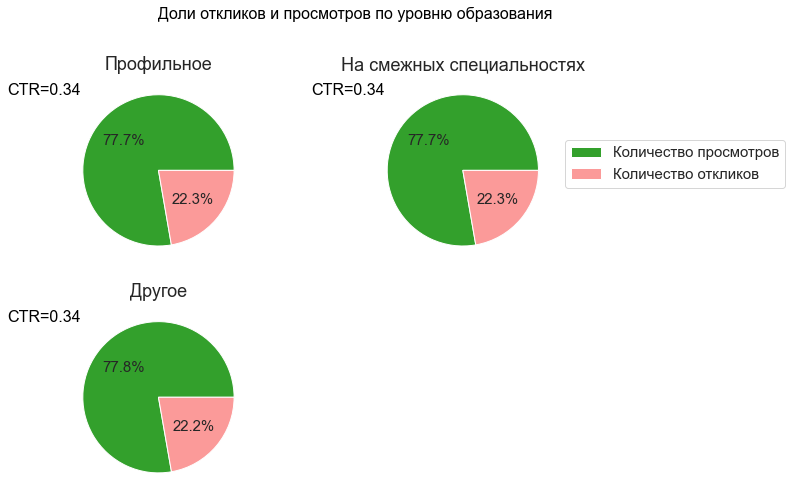

In [38]:
employment = vacancy['Образование'].unique().tolist()
employment_list = vacancy['Образование'].tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))

fig = plt.figure(figsize=(10,16))
for f in range(0,len(form)):
    colors = sns.color_palette('Paired')[3:8]
    plt.rc('font', size= 15 )
    plt.subplot(4, 2, f+1)

    views = pd.Series({'Количество просмотров':data[pd.Series(map(lambda x:  x.__contains__(form[f]) , employment_list))]['Количество просмотров'].sum()})
    responses = pd.Series({'Количество откликов':data[pd.Series(map(lambda x:  x.__contains__(form[f]) , employment_list))]['Количество откликов'].sum()})
    pie_data = pd.concat([views,responses],axis= 0)
    ctr = round(vacancy[list(map(lambda x:  x.__contains__(form[f]) , employment_list))]['CTR'].mean(),2)

    plt.pie(pie_data, autopct='%1.1f%%',
            colors=colors)
           # explode=explode)
    plt.title(form[f])
    plt.text(-2, 1, f'CTR={ctr}', fontsize=16, color='black')

    if f==1:
        plt.legend(pie_data.index, bbox_to_anchor=(1.00, 0.7))



plt.text(0,5, "Доли откликов и просмотров по уровню образования", fontsize=16, color='black')
plt.show()

___
Доли откликов и просмотров для различных уровней образования практически равны
___

Нулевая гипотеза: `Уровень образования, указанный в вакансии, не влияет на конверсию в отклики`

Альтернативная гипотеза: `Уровень образования, указанный в вакансии, влияет на конверсию в отклики`

Для проверки гипотезы будем использовать однофакторный ANOVA-анализ и метод Холма, в качестве поправки на множественное сравнение.

In [39]:

data = vacancy

employment = vacancy['Образование'].unique().tolist()
em = []
for e in employment:
#     print(e.split(', '))
    em.append(e.split(', '))
form = []
for group in em:
    for name in group:
        form.append(name)
form = list(set(form ))

p_value = []

for f in form:

    employment_list = data['Образование'].tolist()
    full_time_data = data[pd.Series(map(lambda x:  x.__contains__(f) , employment_list))]['Количество откликов']
    other_data = data[pd.Series(map(lambda x:  not x.__contains__(f) , employment_list))]['Количество откликов']


    f_stat, p_val = f_oneway(full_time_data, other_data)
    p_value.append(p_val)


alpha = 0.05

# Применяем метод Холма для коррекции p-значений
reject, corrected_p_values, alphacSidak, alphacBonf = multipletests(p_value, method='holm')

# Выводим результаты
results = pd.DataFrame({'corrected_p_values':corrected_p_values})


for f in range(len(form)):
    if results.loc[f,'corrected_p_values'] < alpha:
        print(f"Отвергаем нулевую гипотезу: Есть статистически значимые различия в среднем количестве откликов между вакансиями  с уровнем образования {form[f]} и другими")
    else:
        print(f"Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с уровнем образования {form[f]} и другими")
    print(' ')

Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с уровнем образования Профильное и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с уровнем образования На смежных специальностях и другими
 
Не удалось отвергнуть нулевую гипотезу: Нет статистически значимого различия в среднем количестве откликов между вакансиями  с уровнем образования Другое и другими
 


**Вывод**
___
При  множественной проверке ANOVA-анализ также не показал значимой разницы между количеством откликов по уровням образования.
___

#### Общий вывод из анализа признаков вакансий привлекающих наибольшее внимание кандидатов
___
* Конверсия в отклики выше при указании формата работы "Офис", в то время как для удаленной работы конверсия, наоборот, меньше.
* Вакансии без ссылки на тестовое задание имеют лучшую конверсию. Это может быть связано с уменьшением барьера в виде необходимости выполнения дополнительного задания перед подачей заявки. Кандидаты могут быть более склонны откликнуться на вакансии, где процесс отклика более прост и прямолинеен.
* Не было обнаружено значительной разницы в конверсиях из просмотров в отклики относительно указания формата занятости, города, формата оформления и уровня образования.
___

<a id='theend'></a>
## Общие выводы по исследованию
___
Были выявлены следующие признаки вакансий, привлекающих наибольшее внимание кандидатов и успешно закрывающихся силами агентства:

* Вакансии закрываются лучше в первые 25 дней после размещения. Для увеличения доли успешно закрытых вакансий рекомендовано активно продвигать вакансию в первые  25 дня после размещения.
* Вакансии с удаленным форматом имеют больше шансов быть успешно закрытыми агентством, что может указывать на более эффективный подбор кандидатов или другие причины. Однако несмотря на успешное закрытие, конверсия в отклики у вакансий с удаленным форматом меньше. Это может быть связано с различными факторами, такими как специфика самой вакансии, требования к кандидатам, или даже способ представления информации о вакансии.
* Отмечено, что вакансии с реферальным источником лида закрываются лучше.
* Вакансии без ссылки на тестовое задание имеют лучшую конверсию. Это может быть связано с уменьшением барьера в виде необходимости выполнения дополнительного задания перед подачей заявки.
___